In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from functools import reduce
import pickle

In [2]:
# Add the python path to the folder containing some custom packages.
import sys
sys.path.insert(0, "../dataset/analysis")
import alpha3code_teams

In [3]:
# Set default sizes for figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 15) # fontsize of the x and y labels
plt.rc("axes", titlesize = 15) # fontsize of the axes title
plt.rc("xtick", labelsize = 12) # fontsize of the tick labels
plt.rc("ytick", labelsize = 12) # fontsize of the tick labels
plt.rc("legend", fontsize = 15) # legend fontsize

In [4]:
# Set a value for the column width layout.
pd.options.display.max_colwidth = 20

# Load Data

In [5]:
# Select a competition as example.
COMPETITION = "European_Championship" # Italy, England, France, Germany, Spain, World_Cup, European_Championship

In [6]:
# Define the path where the official released dataset is stored.
path_to_dataset = "../dataset/dataset/"

In [7]:
# Load the events dataset.
events = pd.read_json(path_to_dataset + f"events/events_{COMPETITION}.json", encoding = "unicode_escape")
events.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],26010,"[{'y': 48, 'x': ...",1694390,Pass,4418,1H,1.255990,85,88178642
1,8,Simple pass,[{'id': 1801}],3682,"[{'y': 50, 'x': ...",1694390,Pass,4418,1H,2.351908,85,88178643
2,8,Simple pass,[{'id': 1801}],31528,"[{'y': 48, 'x': ...",1694390,Pass,4418,1H,3.241028,85,88178644
3,8,High pass,[{'id': 1802}],7855,"[{'y': 35, 'x': ...",1694390,Pass,4418,1H,6.033681,83,88178645
4,1,Ground defending...,"[{'id': 702}, {'...",25437,"[{'y': 6, 'x': 8...",1694390,Duel,4418,1H,13.143591,12,88178646


In [8]:
# Load the teams dataset.
teams = pd.read_json(path_to_dataset + "teams.json", encoding = "unicode_escape")
teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,{'name': 'Englan...,club
1,Vigo,Celta de Vigo,692,Real Club Celta ...,{'name': 'Spain'...,club
2,Barcelona,Espanyol,691,Reial Club Depor...,{'name': 'Spain'...,club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,{'name': 'Spain'...,club
4,Valencia,Levante,695,Levante UD,{'name': 'Spain'...,club


In [9]:
# Create 3 alpha code.
teams["code"] = teams["name"].map(alpha3code_teams.alpha3code)

In [10]:
# Create team dictionary: id -> official name.
idToName = teams.set_index("wyId")["officialName"].to_dict()

In [11]:
# Create team dictionary: id -> 3 alpha code.
idToCode = teams.set_index("wyId")["code"].to_dict()

# Auxiliary features

In [12]:
def accuracy(l):
    if {"id": 1801} in l:
        return "acc"
    elif {'id': 1802} in l:
        return "not acc"
    else:
        return "no tag"
    
def successful(l):
    if {"id": 1801} in l:
        return True
    else:
        return False

def assist(l):
    if {"id": 301} in l:
        return True
    else:
        return False

def goal(l):
    if {"id": 101} in l:
        return True
    else:
        return False

def interception(l):
    if {"id": 1401} in l:
        return True
    else:
        return False

In [13]:
# New features.
events["accurate"] = events["tags"].apply(accuracy)
events["successful"] = events["tags"].apply(successful)
events["assist"] = events["tags"].apply(assist)
events["goal"] = events["tags"].apply(goal)
events["interception"] = events["tags"].apply(interception)

## Team ball possession

Get the possession phases (similar to Federico function but more speed).

In [14]:
# Sort values based on time of the matches.
events.sort_values(["matchId", "matchPeriod", "eventSec"], inplace = True)

In [15]:
# Create Series that associates each match with corresponding teams. 
mtch_teams = events.groupby("matchId").apply(lambda x: set(x["teamId"]))

In [16]:
def get_poss(x):
    if x["accurate"] == "not acc":
        # Change possession.
        poss = (mtch_teams.loc[x["matchId"]] - {x["teamId"]}).pop() 
    else:
        poss = x["teamId"]
    return poss

In [17]:
# Get possession on the basis of current situation and previous possession for each match and time period.
tqdm.pandas()
events["poss"] = events.groupby(["matchId", "matchPeriod"], as_index = False, group_keys = False).progress_apply(lambda x: x.apply(get_poss, axis = 1))
events.head()

  0%|          | 0/115 [00:00<?, ?it/s]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,accurate,successful,assist,goal,interception,poss
0,8,Simple pass,[{'id': 1801}],26010,"[{'y': 48, 'x': ...",1694390,Pass,4418,1H,1.255990,85,88178642,acc,True,False,False,False,4418
1,8,Simple pass,[{'id': 1801}],3682,"[{'y': 50, 'x': ...",1694390,Pass,4418,1H,2.351908,85,88178643,acc,True,False,False,False,4418
2,8,Simple pass,[{'id': 1801}],31528,"[{'y': 48, 'x': ...",1694390,Pass,4418,1H,3.241028,85,88178644,acc,True,False,False,False,4418
3,8,High pass,[{'id': 1802}],7855,"[{'y': 35, 'x': ...",1694390,Pass,4418,1H,6.033681,83,88178645,not acc,False,False,False,False,11944
4,1,Ground defending...,"[{'id': 702}, {'...",25437,"[{'y': 6, 'x': 8...",1694390,Duel,4418,1H,13.143591,12,88178646,acc,True,False,False,False,4418


## Action phases

In [18]:
# Action phases: the progressive possession phases of each match.
events["action"] = events.groupby(["matchId"])["poss"].apply(lambda x: (x.diff() != 0).cumsum() - 1) 
events.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,accurate,successful,assist,goal,interception,poss,action
0,8,Simple pass,[{'id': 1801}],26010,"[{'y': 48, 'x': ...",1694390,Pass,4418,1H,1.255990,85,88178642,acc,True,False,False,False,4418,0
1,8,Simple pass,[{'id': 1801}],3682,"[{'y': 50, 'x': ...",1694390,Pass,4418,1H,2.351908,85,88178643,acc,True,False,False,False,4418,0
2,8,Simple pass,[{'id': 1801}],31528,"[{'y': 48, 'x': ...",1694390,Pass,4418,1H,3.241028,85,88178644,acc,True,False,False,False,4418,0
3,8,High pass,[{'id': 1802}],7855,"[{'y': 35, 'x': ...",1694390,Pass,4418,1H,6.033681,83,88178645,not acc,False,False,False,False,11944,1
4,1,Ground defending...,"[{'id': 702}, {'...",25437,"[{'y': 6, 'x': 8...",1694390,Duel,4418,1H,13.143591,12,88178646,acc,True,False,False,False,4418,2


# Main features 

In [19]:
# Create a list where to store all the features computed.
features = []

In [20]:
def boxplot(df, c):
    df["officialName"] = df["teamId"].map(idToName)
    df["code"] = df["teamId"].map(idToCode)
    # Figure.
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.boxplot(y = c, x = "officialName", data = df, ax = ax, 
                showmeans = True , boxprops = {"facecolor": "white", "edgecolor": "black"})
    plt.xticks(rotation = 90)
    plt.grid();

## Average length of passages per match

In [21]:
def calculateDistance(x1, y1, x2, y2):  
    dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
    return dist  

def calculate_distance_pass(l):
    if len(l) < 2:
        distance = 0
    else:
        x1 = l[0]["x"]
        y1 = l[0]["y"]
        x2 = l[1]["x"]
        y2 = l[1]["y"]

        distance = calculateDistance(x1, y1, x2, y2)
    return distance

In [22]:
# Get only events of passages.
passages = events[(events["eventName"] == "Pass")][["matchId", "teamId", "positions"]]
# Compute mean distances of passages.
passages["distance"] = passages["positions"].apply(calculate_distance_pass)
distance_passages = passages.groupby(["matchId", "teamId"], as_index = False).agg(LenMeanPass = ("distance", "mean"))
distance_passages.head()

,matchId,teamId,LenMeanPass
0,1694390,4418,21.657004
1,1694390,11944,24.845460
2,1694391,6697,24.249827
3,1694391,8731,25.188672
4,1694392,6697,22.941982


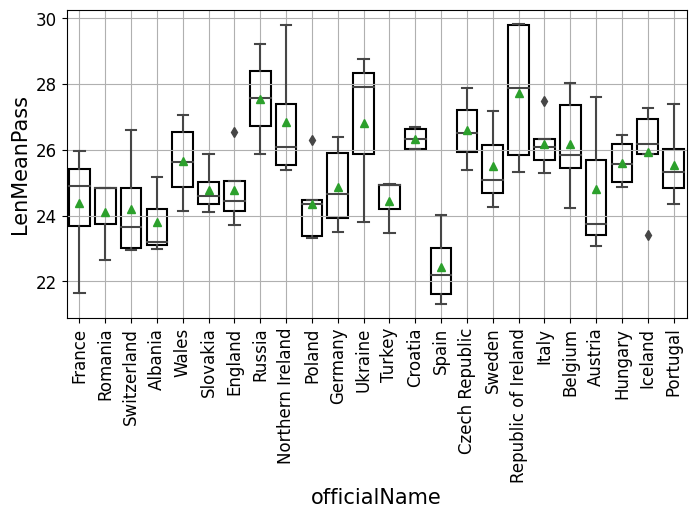

In [23]:
boxplot(distance_passages, "LenMeanPass")

In [24]:
features.append(distance_passages)

## Fraction passages into opposite field (successful passages only) per match

In [25]:
def opponent_field(l):
    x1 = l[0]["x"]
    x2 = l[1]["x"]
    
    if x1 > 50 and x2 > 50:
        return True
    else:
        return False

In [26]:
# Get only successful passages.
passages = events[(events["eventName"] == "Pass") & (events["successful"] == True)][["matchId", "teamId", "positions"]]
# Compute passages into opponent field.
passages["pass_opponent_field"] = passages["positions"].apply(opponent_field)
pass_opponent_field = passages.groupby(["matchId", "teamId"], as_index = False).agg(FracPassOpp = ("pass_opponent_field", lambda x: x.sum() / x.count()))
pass_opponent_field.head()

,matchId,teamId,FracPassOpp
0,1694390,4418,0.408115
1,1694390,11944,0.391304
2,1694391,6697,0.365751
3,1694391,8731,0.271903
4,1694392,6697,0.311804


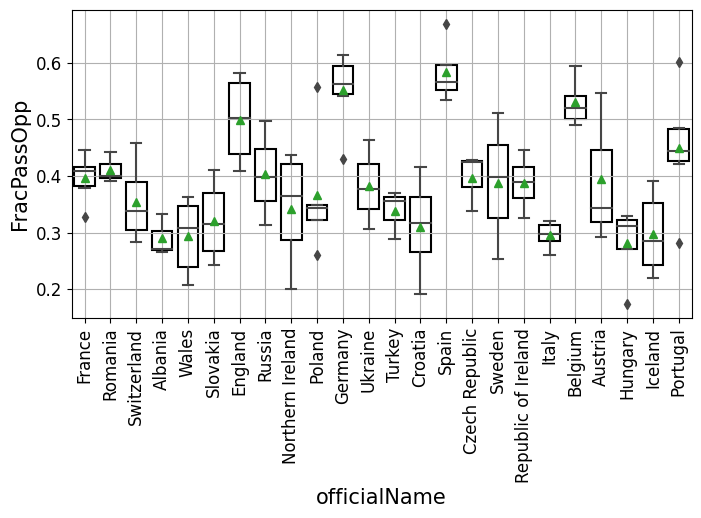

In [27]:
boxplot(pass_opponent_field, "FracPassOpp")

In [28]:
features.append(pass_opponent_field)

## Average position of passages on the x-axis (successful passages only) per match

In [29]:
def calculate_mean_distance_pass(l):
    x1 = l[0]["x"]
    x2 = l[1]["x"]
    
    mean = (x2 + x1)/2    
    return mean

In [30]:
# Get only successful events of passages.
passages = events[(events["eventName"] == "Pass") & (events["successful"] == True)][["matchId", "teamId", "positions"]]
# Compute mean x position of the passages.
passages["distance_mean"] = passages["positions"].apply(calculate_mean_distance_pass)
distance_mean_passagges = passages.groupby(["matchId", "teamId"], as_index = False).agg(PosMeanPass = ("distance_mean", "mean"))
distance_mean_passagges.head()

,matchId,teamId,PosMeanPass
0,1694390,4418,51.026253
1,1694390,11944,51.814010
2,1694391,6697,50.080338
3,1694391,8731,45.300604
4,1694392,6697,48.687082


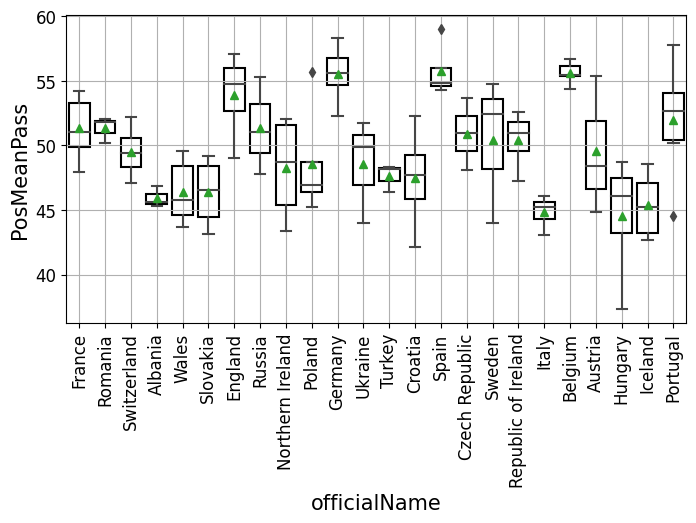

In [31]:
boxplot(distance_mean_passagges, "PosMeanPass")

In [32]:
features.append(distance_mean_passagges)

## Standard devition of the distance of the goal shots per match

In [33]:
def calculate_distance_goal_shot(l):
    x1 = l[0]["x"]
    y1 = l[0]["y"]
    x2 = 100
    y2 = 50

    distance = calculateDistance(x1, y1, x2, y2)
    return distance

In [34]:
# Get only goal shots.
shots = events[(events["eventName"] == "Shot") & (events["goal"] == True)][["matchId", "teamId", "positions"]]
# Compute distance shot goal from opposing goal.
shots["distance"] = shots["positions"].apply(calculate_distance_goal_shot)
# Compute standard deviation of the shots goal distances.
distance_goal_shots = shots.groupby(["matchId", "teamId"], as_index = False).agg(StdDistanceGoal = ("distance", "std"))
distance_goal_shots.head()

,matchId,teamId,StdDistanceGoal
0,1694390,4418,12.114861
1,1694391,6697,NaN
2,1694392,6697,NaN
3,1694393,4418,1.839517
4,1694395,8731,NaN


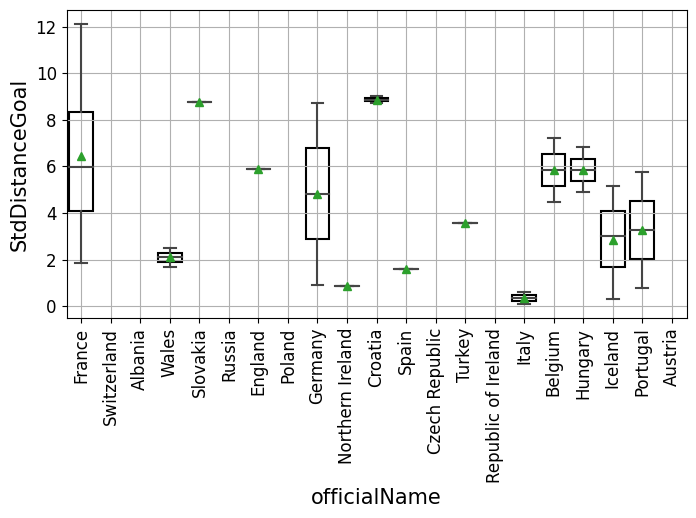

In [35]:
boxplot(distance_goal_shots, "StdDistanceGoal")

In [36]:
features.append(distance_goal_shots)

## Average distance on the x-axis of all shots per match

In [37]:
def calculate_x_shot(l):
    x1 = l[0]["x"]
    x2 = 100
    
    distance = x2 - x1
    return distance

In [38]:
# Get all shots.
shots = events[((events["eventName"] == "Shot"))][["matchId", "teamId", "positions"]]
# Compute x-distance of the shots.
shots["distance"] = shots["positions"].apply(calculate_x_shot)
distance_shots = shots.groupby(["matchId", "teamId"], as_index = False).agg(DistMeanShots = ("distance", "mean"))
distance_shots.head()

,matchId,teamId,DistMeanShots
0,1694390,4418,15.500000
1,1694390,11944,15.750000
2,1694391,6697,17.428571
3,1694391,8731,13.000000
4,1694392,6697,13.357143


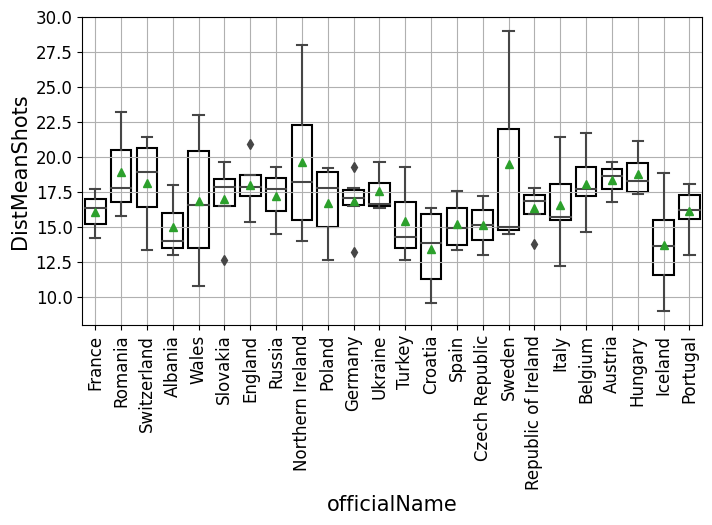

In [39]:
boxplot(distance_shots, "DistMeanShots")

In [40]:
features.append(distance_shots)

## Fouls committed per match

In [41]:
# Compute the number of fouls committed by teams into each match.
fouls_committed = events[events["eventName"] == "Foul"].groupby(["matchId", "teamId"], as_index = False).agg(FoulsComm = ("teamId", "size"))
fouls_committed.head()

,matchId,teamId,FoulsComm
0,1694390,4418,6
1,1694390,11944,15
2,1694391,6697,17
3,1694391,8731,10
4,1694392,6697,11


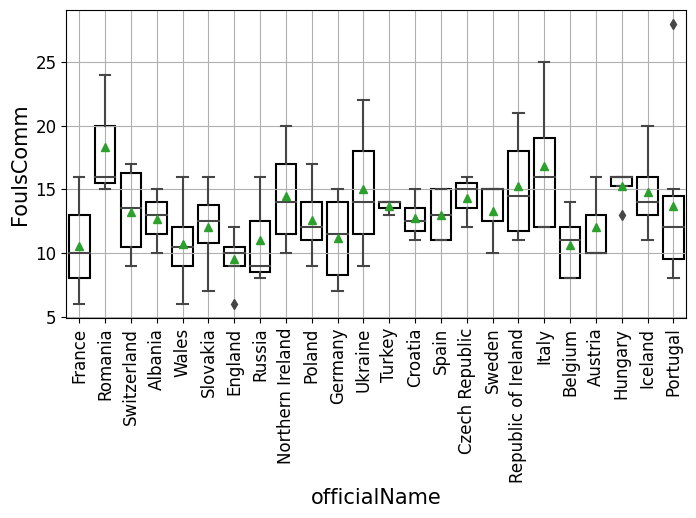

In [42]:
boxplot(fouls_committed, "FoulsComm")

In [43]:
features.append(fouls_committed)

## Ball recovery position on the x-axis per match

In [44]:
def extract_position(l):
    if len(l) > 1:
        return l[1]["x"]
    else:
        return l[0]["x"]

In [45]:
# Get the successful defensive recoveries.
defensive_recoveries = events[((events["subEventName"] == "Ground defending duel") | (events["interception"] == True)) & (events["successful"] == True)][["matchId", "teamId", "positions"]]
# Compute x-distance of the recoveries.
defensive_recoveries["x_recovery"] = defensive_recoveries["positions"].apply(extract_position)
position_recoveries = defensive_recoveries.groupby(["matchId", "teamId"], as_index = False).agg(PosRecBall = ("x_recovery", "mean"))
position_recoveries.head()

,matchId,teamId,PosRecBall
0,1694390,4418,38.196970
1,1694390,11944,43.531646
2,1694391,6697,44.185185
3,1694391,8731,44.386364
4,1694392,6697,36.901961


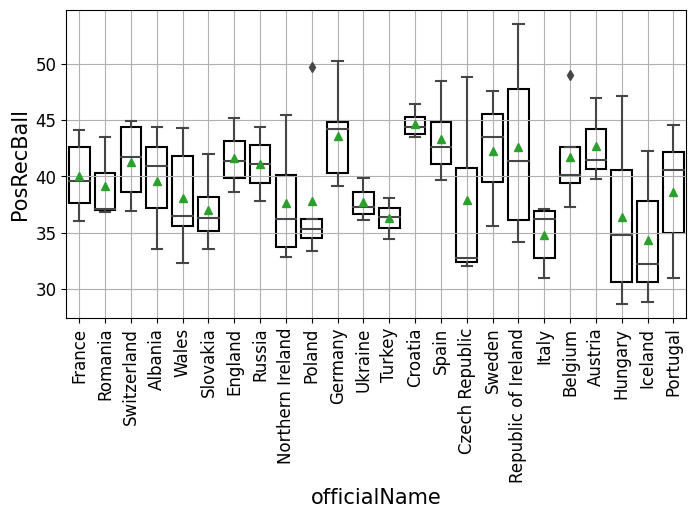

In [46]:
boxplot(position_recoveries, "PosRecBall")

In [47]:
features.append(position_recoveries)

## Median direction passages per match

In [48]:
def calculate_difference(l):
    if len(l) > 1:
        a = l[0]
        b = l[1]
        angle = np.degrees(np.arctan2(b["y"] - a["y"], b["x"] - a["x"]))
        if angle < 0:
            difference = np.abs(angle + 90)
        else:
            difference = np.abs(angle - 90)
        return difference
    else:
        return 0

In [49]:
# Get only events of passages.
passages = events[(events["eventName"] == "Pass")][["matchId", "teamId", "positions"]]
# Compute direction of passages.
passages["direction"] = passages["positions"].apply(calculate_difference)
direction_passages = passages.groupby(["matchId", "teamId"], as_index = False).agg(DirMeanPass = ("direction", "median"))
direction_passages.head()

,matchId,teamId,DirMeanPass
0,1694390,4418,33.690068
1,1694390,11944,45.000000
2,1694391,6697,30.963757
3,1694391,8731,37.320095
4,1694392,6697,35.537678


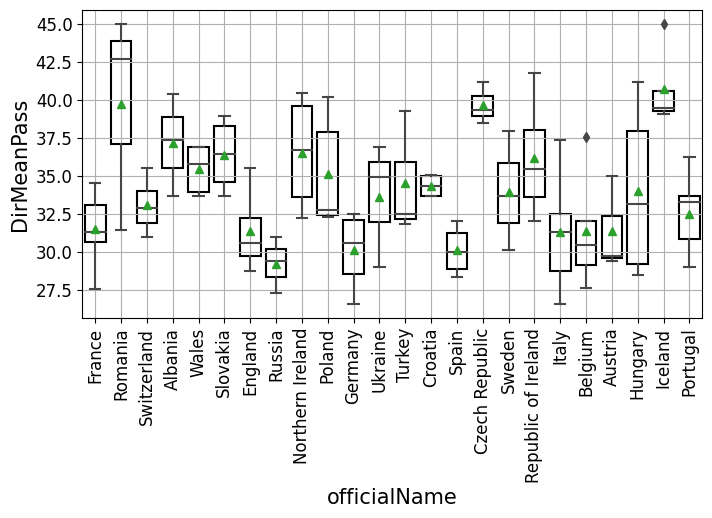

In [50]:
boxplot(direction_passages, "DirMeanPass")

In [51]:
features.append(direction_passages)

## Assist position per match

In [52]:
def extract_centre_position_assist(l):
    if ((l[0]["y"] <= 70) and (l[0]["y"] >= 30)):
        return True
    else:
        return False

In [53]:
# Get assist.
assist = events[events["assist"]][["matchId", "teamId", "positions"]]
# Get the assist into centre position.
assist["y_assist"] = assist["positions"].apply(extract_centre_position_assist)
# Compute fraction of assist into centre position.
position_assist = assist.groupby(["matchId", "teamId"], as_index = False).agg(posCentreAssist = ("y_assist", lambda x: x.sum() / x.count()))
position_assist.head()

,matchId,teamId,posCentreAssist
0,1694390,4418,0.0
1,1694391,6697,0.0
2,1694392,6697,1.0
3,1694393,4418,0.0
4,1694395,8731,0.0


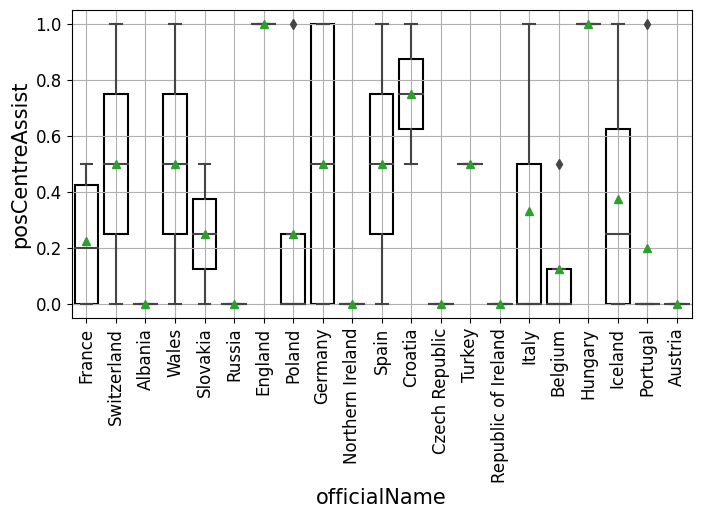

In [54]:
boxplot(position_assist, "posCentreAssist")

In [55]:
features.append(position_assist)

## Consecutive passages per match

In [56]:
# Get only accurate passages.
accurate_passages = events[(events["eventName"] == "Pass") & (events["accurate"] == "acc")][["matchId", "teamId", "poss", "action"]]
# Count consecutive passages into each action.
consecutive_passages = accurate_passages.groupby(["matchId", "poss", "action"], as_index = False).agg(passConsec = ("teamId", "count"))
consecutive_passages.rename({"poss": "teamId"}, axis = 1, inplace = True)
# Keep the mean of consecutive actions in each action of each match.
consecutive_passages = consecutive_passages.groupby(["matchId", "teamId"], as_index = False).agg(passConsec = ("passConsec", "mean"))
consecutive_passages.head()

,matchId,teamId,passConsec
0,1694390,4418,3.521008
1,1694390,11944,2.134021
2,1694391,6697,5.141304
3,1694391,8731,3.377551
4,1694392,6697,4.119266


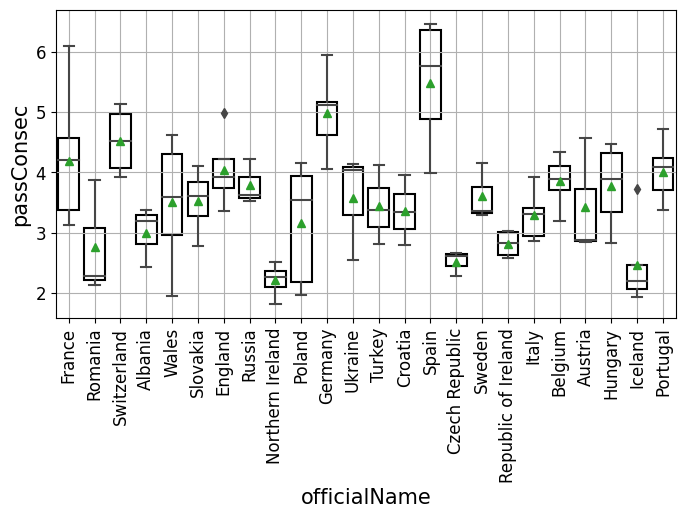

In [57]:
boxplot(consecutive_passages, "passConsec")

In [58]:
features.append(consecutive_passages)

## Ball recovery time per match

In [59]:
# Get duration of each action of each match. 
deltaTime = events.groupby(["matchId", "poss", "action"], as_index = False).agg(timeAction = ("eventSec", lambda x: x.max() - x.min()))
deltaTime.rename({"poss": "teamId"}, axis = 1, inplace = True)
# Keep the median of the duration of each action of each match.
deltaTime = deltaTime.groupby(["matchId", "teamId"], as_index = False).agg(timeAction = ("timeAction", "median"))

# Reverse the teamId of each match: the ball recovery time will be this duration respect to other team.
for i in range(1, len(deltaTime), 2):
    tmp = deltaTime.loc[i, "teamId"]
    deltaTime.loc[i, "teamId"] = deltaTime.loc[i-1, "teamId"]
    deltaTime.loc[i-1, "teamId"] = tmp

deltaTime.rename({"timeAction": "tempRecBall"}, axis = 1, inplace = True)    
deltaTime.head()

,matchId,teamId,tempRecBall
0,1694390,11944,2.950314
1,1694390,4418,1.090426
2,1694391,8731,2.064225
3,1694391,6697,2.657092
4,1694392,11944,2.700322


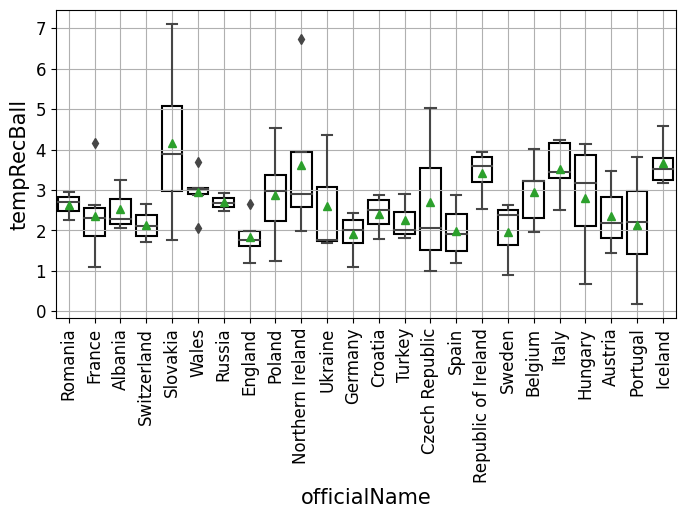

In [60]:
boxplot(deltaTime, "tempRecBall")

In [61]:
features.append(deltaTime)

## Player involvement per match

In [62]:
# Get passages and shots.
shotsPassages = events[events["eventName"].isin(["Pass", "Shot"])] 
# Get number of players involved into each action (passages and shots).
involvement = shotsPassages.groupby(["matchId", "poss", "action"], as_index = False).agg(involPlayers = ("playerId", lambda x: x.nunique()))
#involvement = involvement[involvement["involPlayers"] > 2]
involvement.rename({"poss": "teamId"}, axis = 1, inplace = True)
# Keep the mean of the number of players involved in each action of each match.
involvement = involvement.groupby(["matchId", "teamId"], as_index = False).agg(involPlayers = ("involPlayers", "mean"))
involvement.head()

,matchId,teamId,involPlayers
0,1694390,4418,2.527607
1,1694390,11944,1.823529
2,1694391,6697,3.221311
3,1694391,8731,2.511278
4,1694392,6697,3.007143


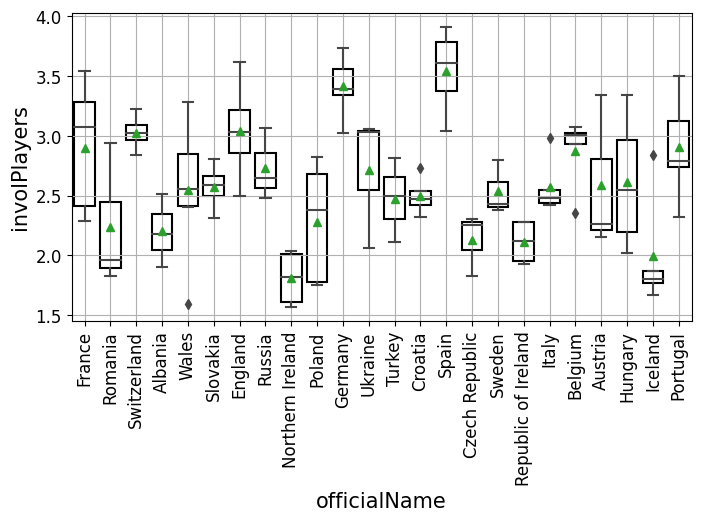

In [63]:
boxplot(involvement, "involPlayers")

In [64]:
features.append(involvement)

# Features concatenation

In [65]:
# Concatenate dataframes.
df = reduce(lambda left, right: pd.merge(left, right, on = ["matchId", "teamId", "officialName", "code"], how = "outer"), features)
df.head()

,matchId,teamId,LenMeanPass,officialName,code,FracPassOpp,PosMeanPass,StdDistanceGoal,DistMeanShots,FoulsComm,PosRecBall,DirMeanPass,posCentreAssist,passConsec,tempRecBall,involPlayers
0,1694390,4418,21.657004,France,FRA,0.408115,51.026253,12.114861,15.500000,6,38.196970,33.690068,0.0,3.521008,1.090426,2.527607
1,1694390,11944,24.845460,Romania,ROU,0.391304,51.814010,NaN,15.750000,15,43.531646,45.000000,NaN,2.134021,2.950314,1.823529
2,1694391,6697,24.249827,Switzerland,CHE,0.365751,50.080338,NaN,17.428571,17,44.185185,30.963757,0.0,5.141304,2.657092,3.221311
3,1694391,8731,25.188672,Albania,ALB,0.271903,45.300604,NaN,13.000000,10,44.386364,37.320095,NaN,3.377551,2.064225,2.511278
4,1694392,6697,22.941982,Switzerland,CHE,0.311804,48.687082,NaN,13.357143,11,36.901961,35.537678,1.0,4.119266,1.713754,3.007143


In [66]:
# Save features.
features = df.groupby(["officialName", "code"]).mean()
features.drop(["matchId", "teamId"], axis = 1, inplace = True)
features.fillna(0, inplace = True)
features.head()

,,LenMeanPass,FracPassOpp,PosMeanPass,StdDistanceGoal,DistMeanShots,FoulsComm,PosRecBall,DirMeanPass,posCentreAssist,passConsec,tempRecBall,involPlayers
officialName,code,,,,,,,,,,,,
Albania,ALB,23.795870,0.290549,45.923595,0.000000,15.000000,12.666667,39.602542,37.124900,0.000,3.001218,2.531381,2.200098
Austria,AUT,24.817758,0.394803,49.561285,0.000000,18.338889,12.000000,42.747863,31.364885,0.000,3.429355,2.365275,2.586145
Belgium,BEL,26.183937,0.529947,55.616597,5.849040,18.088200,10.600000,41.696599,31.358126,0.125,3.849402,2.940009,2.877209
Croatia,HRV,26.341299,0.310571,47.459636,8.867456,13.382440,12.750000,44.686417,34.355153,0.750,3.357048,2.414451,2.497571
Czech Republic,CZE,26.594462,0.396469,50.905221,0.000000,15.117949,14.333333,37.867019,39.663796,0.000,2.518214,2.693090,2.128888


In [67]:
# Save node attributes.
with open(f"./output/team_style_{COMPETITION}.pkl", "wb") as f:
    pickle.dump(features, f)